In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import re
import wrangle

pd.options.display.max_colwidth = None
pd.options.display.max_columns = None
pd.options.display.max_rows = None

import warnings
warnings.filterwarnings('ignore')

plt.rc('figure', figsize=(20,10))

import nltk

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
# pip install pyLDAvis
import pyLDAvis
import pyLDAvis.sklearn

import pickle

In [2]:
hotel = wrangle.wrangle_hotel()

# NLP: Topic Modeling

## SKLearn

### Positive topics

In [3]:
data = hotel.positive_lemma.tolist()

In [4]:
vectorizer = CountVectorizer(min_df=10,
                             stop_words='english',
                             token_pattern='[a-zA-Z0-9]{3,}')

In [5]:
data_vectorized = vectorizer.fit_transform(data)

In [6]:
# Build LDA Model
lda_model = LatentDirichletAllocation(learning_method='online',   
                                      random_state=172,
                                      n_jobs = -1)

In [7]:
lda_output = lda_model.fit_transform(data_vectorized)

In [8]:
with open('lda_output.csv', 'wb') as f:
    pickle.dump(lda_output, f)
    
with open('lda_output.csv', 'rb') as f:
    lda_output = pickle.load(f)

In [9]:
# Materialize the sparse data
data_dense = data_vectorized.todense()

In [10]:
# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  0.10660336453388304 %


In [11]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

Log Likelihood:  -28152154.2266512


In [12]:
# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

Perplexity:  565.9513515438285


In [13]:
# See model parameters
pprint(lda_model.get_params())

{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 10,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': 172,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [14]:
# Create Document - Topic Matrix
lda_output = lda_model.transform(data_vectorized)

In [15]:
# column names
topicnames = ["Topic" + str(i) for i in range(lda_model.n_components)]

In [16]:
# index names
docnames = ["Doc" + str(i) for i in range(len(data))]

In [17]:
# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

In [18]:
# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

In [78]:
dom_top = pd.DataFrame(dominant_topic)

In [79]:
dom_top.to_csv('dominant_topic.csv')

In [19]:
# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

In [20]:
# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
Doc0,0.270000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.520000,0.030000,8
Doc1,0.020000,0.020000,0.020000,0.020000,0.320000,0.020000,0.020000,0.020000,0.020000,0.520000,9
Doc2,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.770000,9
Doc3,0.240000,0.180000,0.010000,0.100000,0.010000,0.010000,0.440000,0.010000,0.010000,0.010000,6
Doc4,0.020000,0.020000,0.020000,0.020000,0.420000,0.220000,0.220000,0.020000,0.020000,0.020000,4
Doc5,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.700000,9
Doc6,0.010000,0.010000,0.010000,0.440000,0.010000,0.270000,0.110000,0.010000,0.130000,0.010000,3
Doc7,0.010000,0.150000,0.580000,0.010000,0.010000,0.010000,0.100000,0.010000,0.130000,0.010000,2
Doc8,0.010000,0.010000,0.010000,0.340000,0.210000,0.130000,0.280000,0.010000,0.010000,0.010000,3
Doc9,0.180000,0.010000,0.010000,0.470000,0.010000,0.140000,0.010000,0.010000,0.010000,0.170000,3


In [71]:
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
Doc0,0.270000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.520000,0.030000,8
Doc1,0.020000,0.020000,0.020000,0.020000,0.320000,0.020000,0.020000,0.020000,0.020000,0.520000,9
Doc2,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.770000,9
Doc3,0.240000,0.180000,0.010000,0.100000,0.010000,0.010000,0.440000,0.010000,0.010000,0.010000,6
Doc4,0.020000,0.020000,0.020000,0.020000,0.420000,0.220000,0.220000,0.020000,0.020000,0.020000,4
Doc5,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.700000,9
Doc6,0.010000,0.010000,0.010000,0.440000,0.010000,0.270000,0.110000,0.010000,0.130000,0.010000,3
Doc7,0.010000,0.150000,0.580000,0.010000,0.010000,0.010000,0.100000,0.010000,0.130000,0.010000,2
Doc8,0.010000,0.010000,0.010000,0.340000,0.210000,0.130000,0.280000,0.010000,0.010000,0.010000,3
Doc9,0.180000,0.010000,0.010000,0.470000,0.010000,0.140000,0.010000,0.010000,0.010000,0.170000,3


In [21]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")

In [22]:
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,0,121907
1,4,106757
2,1,73938
3,9,46349
4,5,44183
5,3,36268
6,6,32025
7,2,24046
8,7,16848
9,8,13417


In [23]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, data_vectorized, vectorizer, mds='tsne')
panel

/opt/homebrew/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/homebrew/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/homebrew/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/homebrew/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/homebrew/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: Deprecatio

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
4      32.420952   8.115230       1        1  12.800422
5       0.648955  71.707100       2        1  12.339283
1      71.019684   9.971006       3        1  12.230794
0       3.785981  33.185135       4        1  11.922004
9     -42.666500  -9.222070       5        1   9.697784
3      -3.621689 -43.526516       6        1   9.385224
6      -3.632402  -4.171708       7        1   9.248346
7     -36.584400  35.804413       8        1   7.827119
2      44.391380  50.615383       9        1   7.506622
8      40.235809 -31.591665      10        1   7.042403, topic_info=                Term           Freq          Total Category  logprob  loglift
4067        location  177224.000000  177224.000000  Default  30.0000  30.0000
6510           staff  185572.000000  185572.000000  Default  29.0000  29.0000
3093            good  108455.000000  108455.000000  Default  28.0000  28.0000
5874            room  175925.000000  175925.000000  Default  27.0000  27.0000
999        breakfast   86873.000000   86873.000000  Default  26.0000  26.0000
786              bed   64855.000000   64855.000000  Default  25.0000  25.0000
3152           great  101629.000000  101629.000000  Default  24.0000  24.0000
1534     comfortable   56842.000000   56842.000000  Default  23.0000  23.0000
2919        friendly   81188.000000   81188.000000  Default  22.0000  22.0000
3332         helpful   71852.000000   71852.000000  Default  21.0000  21.0000
1420           clean   62890.000000   62890.000000  Default  20.0000  20.0000
4622            nice   67436.000000   67436.000000  Default  19.0000  19.0000
4120          lovely   34295.000000   34295.000000  Default  18.0000  18.0000
3433           hotel  129883.000000  129883.000000  Default  17.0000  17.0000
1458           close   30651.000000   30651.000000  Default  16.0000  16.0000
2526       excellent   60266.000000   60266.000000  Default  15.0000  15.0000
6122         service   27448.000000   27448.000000  Default  14.0000  14.0000
6551         station   32412.000000   32412.000000  Default  13.0000  13.0000
7428            walk   21984.000000   21984.000000  Default  12.0000  12.0000
7373            view   22806.000000   22806.000000  Default  11.0000  11.0000
6554            stay   31308.000000   31308.000000  Default  10.0000  10.0000
1542           comfy   21875.000000   21875.000000  Default   9.0000   9.0000
2635        facility   17090.000000   17090.000000  Default   8.0000   8.0000
5752      restaurant   27876.000000   27876.000000  Default   7.0000   7.0000
5014         perfect   24874.000000   24874.000000  Default   6.0000   6.0000
751         bathroom   18989.000000   18989.000000  Default   5.0000   5.0000
536             area   19931.000000   19931.000000  Default   4.0000   4.0000
4410          minute   15030.000000   15030.000000  Default   3.0000   3.0000
1398            city   16020.000000   16020.000000  Default   2.0000   2.0000
2283            easy   15685.000000   15685.000000  Default   1.0000   1.0000
1333           check   10873.064284   10873.940814   Topic1  -3.9568   2.0556
5814           right    8867.684951    8868.561522   Topic1  -4.1606   2.0556
6723          superb    5914.936066    5915.812497   Topic1  -4.5656   2.0555
6416             spa    4147.678452    4148.554914   Topic1  -4.9205   2.0555
5871            roof    3508.145478    3509.021941   Topic1  -5.0880   2.0554
3473            hyde    2776.496760    2777.373208   Topic1  -5.3219   2.0554
3393            home    2746.870931    2747.747490   Topic1  -5.3326   2.0554
5637        relaxing    2049.036477    2049.912993   Topic1  -5.6257   2.0553
1479        cocktail    1828.688968    1829.565461   Topic1  -5.7394   2.0552
685              bad    1728.464794    1729.341409   Topic1  -5.7958   2.0552
1409           class    1676.938068    1677.814528   Topic1  -5.8261   2.0552
6485     

In [24]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(lda_model.components_)

In [25]:
# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

In [31]:
# View
df_topic_keywords.head()

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,room,bed,comfortable,clean,nice,comfy,bathroom,spacious,good,great,shower,big,size,large,really
Topic 1,staff,friendly,helpful,room,clean,breakfast,reception,modern,extremely,super,choice,pleasant,liked,kind,amazing
Topic 2,service,room,facility,coffee,excellent,tea,water,cleanliness,warm,birthday,upgrade,highly,food,overall,hot
Topic 3,room,lovely,hotel,view,nice,beautiful,quiet,like,great,bar,located,quite,floor,paris,restaurant
Topic 4,location,great,staff,excellent,friendly,hotel,perfect,helpful,amazing,check,fantastic,right,stay,polite,superb


In [80]:
df_topic_keywords.to_csv('pos_topic_keyword.csv')

In [32]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

In [33]:
topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=15)        

In [34]:
# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,room,bed,comfortable,clean,nice,comfy,bathroom,spacious,good,great,shower,big,size,large,really
Topic 1,staff,friendly,helpful,room,clean,breakfast,reception,modern,extremely,super,choice,pleasant,liked,kind,amazing
Topic 2,service,room,facility,coffee,excellent,tea,water,cleanliness,warm,birthday,upgrade,highly,food,overall,hot
Topic 3,room,lovely,hotel,view,nice,beautiful,quiet,like,great,bar,located,quite,floor,paris,restaurant
Topic 4,location,great,staff,excellent,friendly,hotel,perfect,helpful,amazing,check,fantastic,right,stay,polite,superb
Topic 5,hotel,stay,time,night,day,best,value,really,place,loved,pool,stayed,money,little,extra
Topic 6,close,station,hotel,city,easy,walking,train,distance,restaurant,centre,access,min,tram,tube,center
Topic 7,walk,minute,near,street,convenient,station,away,bus,stop,parking,quiet,tube,door,tower,air
Topic 8,hotel,restaurant,area,central,wonderful,lot,small,london,shop,transport,help,public,recommend,fabulous,needed
Topic 9,good,breakfast,location,nice,excellent,metro,food,hotel,price,quality,buffet,efficient,selection,really,trip


In [35]:
# Construct the k-means clusters
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=15, random_state=100).fit_predict(lda_output)

In [36]:
# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components

In [37]:
lda_output_svd = svd_model.fit_transform(lda_output)

In [38]:
# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

In [39]:
# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Component's weights: 
 [[ 0.38  0.36  0.2   0.24  0.6   0.26  0.21  0.17  0.18  0.31]
 [-0.33 -0.41 -0.07 -0.12  0.78 -0.13 -0.08 -0.06 -0.06 -0.25]]
Perc of Variance Explained: 
 [0.03 0.24]


Text(0.5, 1.0, 'Segregation of Topic Clusters')

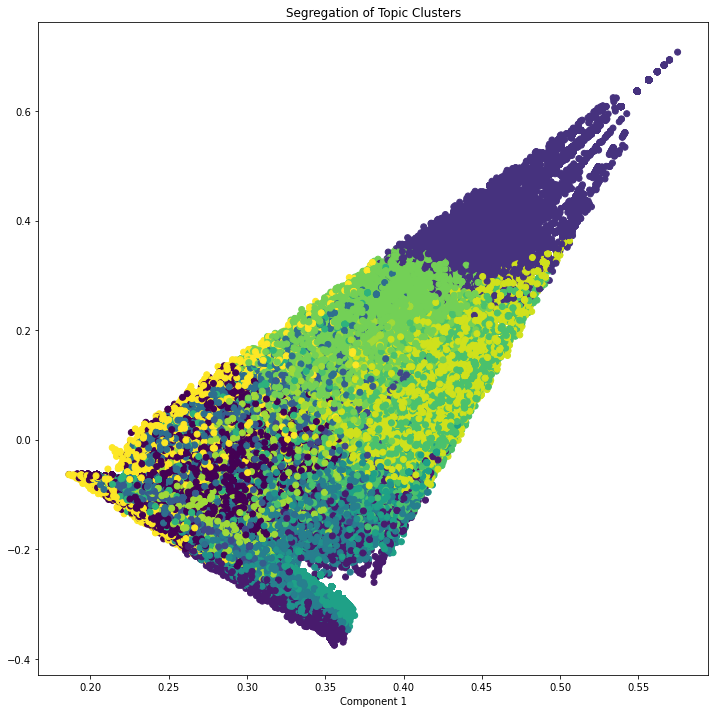

In [40]:
# Plot
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )


### Negative Topics

In [84]:
negative_data = hotel.negative_lemma.tolist()

In [85]:
negative_vectorizer = CountVectorizer(min_df=10,
                             stop_words='english',
                             token_pattern='[a-zA-Z0-9]{3,}')

In [86]:
negative_data_vectorized = negative_vectorizer.fit_transform(negative_data)

In [87]:
#Build LDA Model
negative_lda_model = LatentDirichletAllocation(learning_method='online',   
                                      random_state=172,
                                      n_jobs = -1)

In [88]:
negative_lda_output = negative_lda_model.fit_transform(negative_data_vectorized)

In [89]:
with open('negative_lda_output.csv', 'wb') as f:
    pickle.dump(negative_lda_output, f)
    
with open('negative_lda_output.csv', 'rb') as f:
    negative_lda_output = pickle.load(f)

In [90]:
# Materialize the sparse data
negative_data_dense = negative_data_vectorized.todense()

In [91]:
# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((negative_data_dense > 0).sum()/negative_data_dense.size)*100, "%")

Sparsicity:  0.07287420627221519 %


In [92]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", negative_lda_model.score(negative_data_vectorized))

Log Likelihood:  -27146505.5000388


In [93]:
# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", negative_lda_model.perplexity(negative_data_vectorized))

Perplexity:  1302.4387341477188


In [94]:
# See model parameters
pprint(negative_lda_model.get_params())

{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 10,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': 172,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [95]:
# Create Document - Topic Matrix
negative_lda_output = negative_lda_model.transform(negative_data_vectorized)

In [96]:
# column names
negative_topicnames = ["Topic" + str(i) for i in range(negative_lda_model.n_components)]

In [97]:
# index names
negative_docnames = ["Doc" + str(i) for i in range(len(negative_data))]

In [98]:
# Make the pandas dataframe
negative_df_document_topic = pd.DataFrame(np.round(negative_lda_output, 2), columns=negative_topicnames, index=negative_docnames)

In [99]:
# Get dominant topic for each document
negative_dominant_topic = np.argmax(negative_df_document_topic.values, axis=1)
negative_df_document_topic['dominant_topic'] = negative_dominant_topic

In [100]:
negative_dom_top = pd.DataFrame(negative_dominant_topic)
negative_dom_top.to_csv('negative_dominant_topic.csv')

In [101]:
# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

In [102]:
# Apply Style
negative_df_document_topics = negative_df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
negative_df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
Doc0,0.120000,0.070000,0.010000,0.010000,0.370000,0.010000,0.230000,0.010000,0.130000,0.070000,4
Doc1,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0
Doc2,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0
Doc3,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0
Doc4,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0
Doc5,0.010000,0.010000,0.010000,0.850000,0.010000,0.010000,0.010000,0.010000,0.080000,0.010000,3
Doc6,0.010000,0.160000,0.010000,0.010000,0.160000,0.010000,0.300000,0.010000,0.300000,0.010000,6
Doc7,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0
Doc8,0.010000,0.460000,0.010000,0.000000,0.010000,0.040000,0.010000,0.000000,0.030000,0.430000,1
Doc9,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.550000,0.050000,0.050000,7


In [103]:
negative_df_topic_distribution = negative_df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")

In [104]:
negative_df_topic_distribution.columns = ['Topic Num', 'Num Documents']
negative_df_topic_distribution

,Topic Num,Num Documents
0,0,186803
1,2,71546
2,6,51808
3,4,47025
4,9,32573
5,5,31665
6,3,30268
7,1,24206
8,8,22377
9,7,17467


In [105]:
pyLDAvis.enable_notebook()
negative_panel = pyLDAvis.sklearn.prepare(negative_lda_model, negative_data_vectorized, vectorizer, mds='tsne')
negative_panel

/opt/homebrew/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/homebrew/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/homebrew/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/homebrew/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/homebrew/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: Deprecatio

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
6      32.420952   8.115230       1        1  14.658470
9       0.648955  71.707100       2        1  12.973067
2      71.019684   9.971006       3        1  12.533533
4       3.785981  33.185135       4        1  11.021910
3     -42.666500  -9.222070       5        1   9.035818
5      -3.621689 -43.526516       6        1   8.416420
0      -3.632402  -4.171708       7        1   8.061545
8     -36.584400  35.804413       8        1   7.993459
1      44.391380  50.615383       9        1   7.943956
7      40.235809 -31.591665      10        1   7.361822, topic_info=               Term           Freq          Total Category  logprob  loglift
6944           room  204868.000000  204868.000000  Default  30.0000  30.0000
1278      breakfast   58183.000000   58183.000000  Default  29.0000  29.0000
7477          small   47304.000000   47304.000000  Default  28.0000  28.0000
1044            bed   36745.000000   36745.000000  Default  27.0000  27.0000
1009       bathroom   27536.000000   27536.000000  Default  26.0000  26.0000
4823         little   22522.000000   22522.000000  Default  25.0000  25.0000
4102          hotel   81548.000000   81548.000000  Default  24.0000  24.0000
7725          staff   39236.000000   39236.000000  Default  23.0000  23.0000
969             bar   19588.000000   19588.000000  Default  22.0000  22.0000
6206          price   17589.000000   17589.000000  Default  21.0000  21.0000
1134            bit   27227.000000   27227.000000  Default  20.0000  20.0000
3733           good   21178.000000   21178.000000  Default  19.0000  19.0000
2733           door   15710.000000   15710.000000  Default  18.0000  18.0000
3155      expensive   15656.000000   15656.000000  Default  17.0000  17.0000
7221        service   20357.000000   20357.000000  Default  16.0000  16.0000
7329         shower   22121.000000   22121.000000  Default  15.0000  15.0000
3416          floor   16423.000000   16423.000000  Default  14.0000  14.0000
527             air   14117.000000   14117.000000  Default  13.0000  13.0000
1792         coffee   13665.000000   13665.000000  Default  12.0000  12.0000
5431          night   28022.000000   28022.000000  Default  11.0000  11.0000
7774           stay   17564.000000   17564.000000  Default  10.0000  10.0000
4842       location   11424.000000   11424.000000  Default   9.0000   9.0000
3469           food   11639.000000   11639.000000  Default   8.0000   8.0000
1610          check   15076.000000   15076.000000  Default   7.0000   7.0000
3742            got   10728.000000   10728.000000  Default   6.0000   6.0000
5592            old   10654.000000   10654.000000  Default   5.0000   5.0000
4100            hot   12465.000000   12465.000000  Default   4.0000   4.0000
5455          noise   11988.000000   11988.000000  Default   3.0000   3.0000
8982          water   14731.000000   14731.000000  Default   2.0000   2.0000
6077           poor   15432.000000   15432.000000  Default   1.0000   1.0000
1610          check   15075.889899   15076.755349   Topic1  -3.6056   1.9201
5806        parking    9006.866994    9007.732463   Topic1  -4.1207   1.9201
7437          sleep    6883.058014    6883.923540   Topic1  -4.3896   1.9200
3918           hard    6591.156329    6592.021851   Topic1  -4.4329   1.9200
8222          think    6426.516420    6427.381933   Topic1  -4.4582   1.9200
2872          early    5470.287429    5471.152893   Topic1  -4.6193   1.9200
1832    comfortable    5318.854336    5319.719857   Topic1  -4.6474   1.9200
4679           late    5014.430601    5015.296071   Topic1  -4.7063   1.9200
8913           wait    4910.529612    4911.395098   Topic1  -4.7273   1.9200
3726          going    4751.580942    4752.446467   Topic1  -4.7602   1.9200
1611        checked    3589.700627    3590.566113   Topic1  -5.0406   1.9199
8174       terrible    3325.968062    3326.833610  

In [106]:
# Topic-Keyword Matrix
negative_df_topic_keywords = pd.DataFrame(negative_lda_model.components_)

In [107]:
# Assign Column and Index
negative_df_topic_keywords.columns = negative_vectorizer.get_feature_names()
negative_df_topic_keywords.index = negative_topicnames

In [109]:
# View
negative_df_topic_keywords.head()

,000,001,007,00am,00h,00hrs,00pm,05am,0700,0730,0800,0830,0900,0930,100,1000,100m,101,102,103,1030,104,105,106,107,108,109,10am,10euro,10m,10m2,10min,10mins,10minutes,10pm,10th,110,1100,111,112,113,1130,114,115,116,117,118,11am,11pm,11th,120,1200,122,123,124,125,127,128,129,12am,12noon,12pm,12th,130,134,135,137,139,13th,140,1400,140cm,143,145,149,14th,150,1500,155,159,15am,15eur,15euros,15min,15mins,15minutes,15pm,15th,160,1600,165,166,167,168,169,16th,170,175,178,179,17th,180,1800,185,189,18c,18th,190,195,1950,197,1970,1970s,1980,1980s,199,1990,19c,19th,1am,1day,1hour,1hr,1km,1night,1pm,1st,200,2000,200m,201,2014,2015,2016,2017,202,203,204,205,206,207,208,209,20am,20c,20cm,20e,20eur,20euro,20m2,20min,20mins,20minutes,20pm,20th,210,211,212,214,215,216,217,218,219,21st,220,222,2230,224,225,22nd,230,2300,235,239,23rd,240,245,24h,24hour,24hours,24hr,24hrs,24th,250,255,25c,25min,25mins,25th,260,269,26th,270,275,27th,280,28c,28th,290,29th,2am,2days,2hours,2hrs,2km,2nd,2nights,2pm,2star,300,301,302,303,304,305,306,307,308,309,30am,30c,30min,30mins,30minutes,30pm,30th,310,311,312,314,315,318,319,320,325,330,330ml,340,350,355,360,370,380,3am,3days,3pm,3rd,3star,400,401,402,403,404,405,406,407,408,409,40am,40min,40mins,40pm,40th,410,411,412,414,415,416,419,420,424,430,440,450,45am,45min,45mins,45pm,470,4am,4ft,4pm,4star,4stars,4th,500,500m,500ml,501,502,504,505,506,507,508,50am,50cm,50euro,50euros,50m,50pm,50th,510,518,530,550,5am,5euro,5ft,5km,5min,5mins,5pm,5star,5th,600,601,602,603,604,609,60th,611,625,630,650,6am,6ft,6pm,6th,700,701,70th,730,750,7am,7pm,7th,800,830,8am,8pm,8th,900,9am,9pm,9th,aback,abandoned,abd,ability,abit,able,abroad,abrupt,abruptly,absence,absent,absolute,absolutely,absolutly,absurd,absurdly,abt,abundance,abuse,abusive,abysmal,accent,accept,acceptable,accepted,accepting,acces,access,accessable,accessed,accessibility,accessible,accessing,accessory,accident,accidental,accidentally,accidently,accommodate,accommodated,accommodating,accommodation,accomodate,accomodated,accomodating,accomodation,accomodations,accompanied,accompany,accompanying,accor,accordance,according,accordingly,account,accounted,accounting,accross,accumulated,accurate,accurately,accuse,accused,accusing,accustomed,ace,ache,achieve,achieved,aching,acknowledge,acknowledged,acknowledgement,acknowledging,acoustic,acquired,act,acted,acting,action,actioned,activate,activated,active,actively,activity,actual,actually,adamant,adapted,adapter,adaptor,add,added,addict,adding,addition,additional,additionally,address,addressed,addressing,ade,adele,adequate,adequately,adjacent,adjoining,adjust,adjustable,adjusted,adjusting,adjustment,admin,administration,admission,admit,admitted,admittedly,adress,adult,advance,advanced,advantage,adventure,adverse,advert,advertise,advertised,advertisement,advertises,advertising,advice,advisable,advise,advised,adviser,advising,advisor,aerial,aeroplane,aesthetic,aesthetically,affair,affect,affected,affecting,affiliated,afford,affordable,afforded,afraid,africa,african,afterall,afternoon,afterthought,age,aged,ageing,agency,agent,aggressive,aggressively,agile,agin,aging,ago,agree,agreed,agreeing,agreement,agressive,ahead,aid,aim,aimed,aiming,air,airbnb,airco,aircon,aircond,aircondition,airconditioned,airconditioner,airconditioning,aircraft,aired,airflow,airing,airless,airline,airplane,airport,airy,aisle,ajar,ajoining,aka,akin,akward,ala,alarm,alarmed,alarming,albeit,albert,alcohol,alcoholic,alcove,ale,alert,alerted,align,aligned,alike,alittle,alive,alla,alleged,allegedly,allergic,allergy,alley,alleyway,allocate,allocated,allocating,allocation,allot,allotted,allow,allowance,allowed,allowing,allows,allready,allways,ally,aloft,alongside,aloof,alot,aloud,alright,alter,alteration,altered,alternate,alternative,alternatively,altho,althought,altogether,altough,amateur,amateurish,amazed,amazing,amazingly,amba,ambassador,ambiance,ambience,ambient,ambiguous,ambitious,ambulance,amd,amend,amended,amendment,amends,amenity,america,american,american

In [110]:
# Show top n keywords for each topic
def show_topics(vectorizer=negative_vectorizer, lda_model=negative_lda_model, n_words=20):
    keywords = np.array(negative_vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in negative_lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

In [111]:
negative_topic_keywords = show_topics(vectorizer=negative_vectorizer, lda_model=negative_lda_model, n_words=15)        

In [112]:
# Topic - Keywords Dataframe
negative_df_topic_keywords = pd.DataFrame(negative_topic_keywords)
negative_df_topic_keywords.columns = ['Word '+str(i) for i in range(negative_df_topic_keywords.shape[1])]
negative_df_topic_keywords.index = ['Topic '+str(i) for i in range(negative_df_topic_keywords.shape[0])]
negative_df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,little,door,bit,hotel,double,problem,outside,london,car,friendly,extremely,tired,say,staff,need
Topic 1,room,coffee,tea,facility,walk,card,issue,table,smell,away,quality,look,station,paid,second
Topic 2,room,small,bathroom,view,shower,clean,toilet,wall,bit,size,tiny,light,space,dirty,towel
Topic 3,bed,bar,price,shower,water,area,star,hotel,bath,pillow,quite,uncomfortable,charged,glass,taxi
Topic 4,room,floor,hot,noise,poor,noisy,wifi,night,window,work,cold,open,free,slow,lift
Topic 5,breakfast,good,staff,great,service,really,ask,high,came,expected,choice,especially,english,like,restaurant
Topic 6,room,stay,hotel,night,check,time,reception,like,day,bed,parking,morning,sleep,pay,hard
Topic 7,hotel,location,got,old,far,city,single,way,good,hear,elevator,properly,corridor,fridge,disappointing
Topic 8,expensive,air,service,food,better,restaurant,hotel,pool,money,drink,conditioning,use,thing,need,nice
Topic 9,staff,room,hotel,booking,bad,booked,asked,working,told,said,desk,arrived,make,time,com


In [119]:
neg_top_key = pd.DataFrame(negative_df_topic_keywords)
neg_top_key.to_csv('negative_topic_keywords.csv')

In [113]:
# Construct the k-means clusters
from sklearn.cluster import KMeans
negative_clusters = KMeans(n_clusters=15, random_state=100).fit_predict(negative_lda_output)

In [114]:
# Build the Singular Value Decomposition(SVD) model
negative_svd_model = TruncatedSVD(n_components=2)  # 2 components
negative_lda_output_svd = negative_svd_model.fit_transform(negative_lda_output)

In [115]:
# X and Y axes of the plot using SVD decomposition
negative_x = negative_lda_output_svd[:, 0]
negative_y = negative_lda_output_svd[:, 1]

In [116]:
# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(negative_svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(negative_svd_model.explained_variance_ratio_, 2))

Component's weights: 
 [[ 0.28  0.26  0.43  0.29  0.35  0.29  0.37  0.25  0.29  0.31]
 [-0.04 -0.09  0.88 -0.04 -0.19 -0.14 -0.34 -0.04 -0.12 -0.18]]
Perc of Variance Explained: 
 [0.   0.21]


Text(0.5, 1.0, 'Segregation of Topic Clusters')

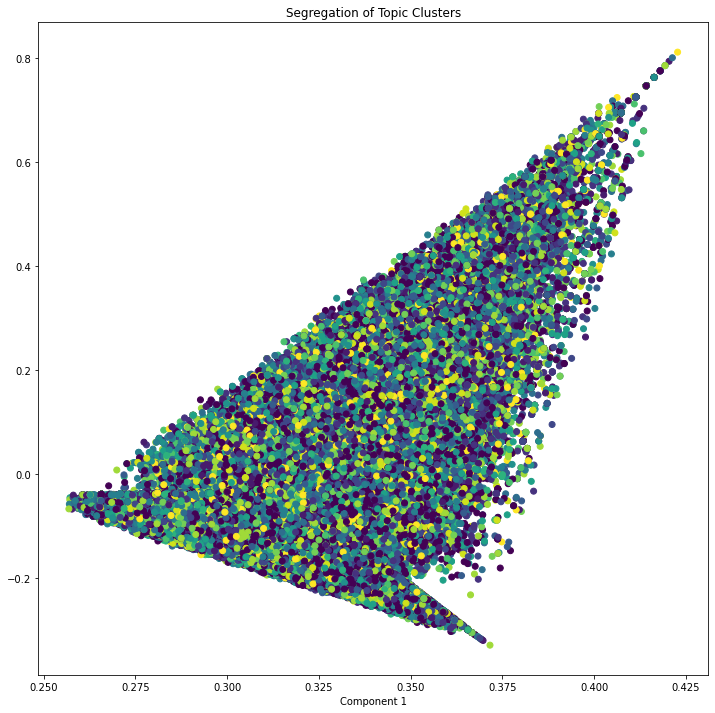

In [117]:
# Plot
plt.figure(figsize=(12, 12))
plt.scatter(negative_x, negative_y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )

# Grid Search

In [118]:
# # Define Search Param
# search_params = {'n_components': [10, 20, 30], 'learning_decay': [.5, .7, .9]}

# # Init the Model
# lda = LatentDirichletAllocation()

# with open('lda.csv', 'wb') as f:
#     pickle.dump(lda, f)
    
# with open('lda.csv', 'rb') as f:
#     lda = pickle.load(f)
    
# # Init Grid Search Class
# model = GridSearchCV(lda, param_grid=search_params)

# with open('grid.csv', 'wb') as f:
#     pickle.dump(model, f)
    
# with open('grid.csv', 'rb') as f:
#     model = pickle.load(f)
    
# # Do the Grid Search
# model.fit(data_vectorized)

In [ ]:
# # Best Model
# best_lda_model = model.best_estimator_

# # Model Parameters
# print("Best Model's Params: ", model.best_params_)

# # Log Likelihood Score
# print("Best Log Likelihood Score: ", model.best_score_)

# # Perplexity
# print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

In [ ]:
# # Get Log Likelyhoods from Grid Search Output
# n_topics = [10, 15, 20, 25, 30]
# log_likelyhoods_5 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.5]
# log_likelyhoods_7 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.7]
# log_likelyhoods_9 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.9]

# # Show graph
# plt.figure(figsize=(12, 8))
# plt.plot(n_topics, log_likelyhoods_5, label='0.5')
# plt.plot(n_topics, log_likelyhoods_7, label='0.7')
# plt.plot(n_topics, log_likelyhoods_9, label='0.9')
# plt.title("Choosing Optimal LDA Model")
# plt.xlabel("Num Topics")
# plt.ylabel("Log Likelyhood Scores")
# plt.legend(title='Learning decay', loc='best')
# plt.show()


# Gensim

In [ ]:
# from pprint import pprint

# # Gensim
# import gensim
# from gensim.models.ldamodel import LdaModel
# import gensim.corpora as corpora
# from gensim.utils import simple_preprocess
# from gensim.models import CoherenceModel

# # Plotting tools
# import pyLDAvis
# import pyLDAvis.gensim_models  # don't skip this

In [ ]:
# data = hotel.positive_lemma.values.tolist()

In [ ]:
# def sent_to_words(sentences):
#     for sentence in sentences:
#         yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

# data_words = list(sent_to_words(data))

# print(data_words[:1])

In [ ]:
# # Create Dictionary
# id2word = corpora.Dictionary(data_words)

# # Create Corpus
# texts = data_words

# # Term Document Frequency
# corpus = [id2word.doc2bow(text) for text in texts]

# # View
# print(corpus[:1])

In [ ]:
# id2word[0]

In [ ]:
# Human readable format of corpus (term-frequency)
# [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

In [ ]:
# Build LDA model
# lda_model = LdaModel(corpus=corpus,id2word=id2word,
#                     num_topics=10, random_state=100)

In [ ]:
# Print the Keyword in the 10 topics
# pprint(lda_model.print_topics())
# doc_lda = lda_model[corpus]

In [ ]:
# # Compute Perplexity
# print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# # Compute Coherence Score
# coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word)
# coherence_lda = coherence_model_lda.get_coherence()
# print('\nCoherence Score: ', coherence_lda)

In [ ]:
# Visualize the topics
# pyLDAvis.enable_notebook()
# vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
# vis